In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd 
pd.options.mode.chained_assignment = None
import datetime as DT
import io
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ucla_state=pd.read_csv("/content/drive/MyDrive/Report/Dataset_preparation/historical_state_counts.csv")
df1=ucla_state[['Date', 'State', 'Residents.Confirmed', 'Staff.Confirmed']]
df1.head(100)

,Date,State,Residents.Confirmed,Staff.Confirmed
0,2020-03-22,Alabama,0.0,1.0
1,2020-03-29,Alabama,0.0,2.0
2,2020-04-05,Alabama,0.0,2.0
3,2020-04-12,Alabama,3.0,6.0
4,2020-04-19,Alabama,4.0,9.0
...,...,...,...,...
95,2022-01-16,Alabama,2762.0,1671.0
96,2022-01-23,Alabama,2922.0,1767.0
97,2022-01-30,Alabama,2985.0,1807.0
98,2022-02-06,Alabama,3028.0,1826.0


In [6]:
us_counties=pd.read_csv("/content/drive/MyDrive/Report/Dataset_preparation/us-counties.csv")
df2=us_counties[['date', 'state', 'cases', 'county']]
df2.head()

,date,state,cases,county
0,2020-01-21,Washington,1,Snohomish
1,2020-01-22,Washington,1,Snohomish
2,2020-01-23,Washington,1,Snohomish
3,2020-01-24,Illinois,1,Cook
4,2020-01-24,Washington,1,Snohomish


In [8]:
prison_pop=pd.read_csv("/content/drive/MyDrive/Report/Dataset_preparation/Prison_pop2020.csv")
prison_pop

,states,pop2020
0,Alabama,"25,328"
1,Alaska,"4,578"
2,Arizona,"37,731"
3,Arkansas,"16,094"
4,California,"97,328"
5,Colorado,"16,168"
6,Connecticut,"9,559"
7,Delaware,"4,710"
8,Florida,"81,027"
9,Georgia,"47,141"


In [9]:
#Pipeline functions

def stateFilter(dataset):
   return  dataset[dataset.iloc[:,1]=='Colorado']
#stateFilter(ucla_state)
transformer1 = FunctionTransformer(stateFilter)

def timeTranform(dateset):
  dateset.iloc[:,0] = pd.to_datetime(dateset.iloc[:,0],format='%Y-%m-%d')
  return  dateset
transformer2 = FunctionTransformer(timeTranform)
#timeTranform(ucla_state)

def timeFilter(dataset):
  filter = (dataset.iloc[:,0] > '2020-04-01') & (dataset.iloc[:,0]  <= '2021-03-31' )
  return dataset.loc[filter]
transformer3 = FunctionTransformer(timeFilter)
#timeFilter(ucla_state).head()

def resetIndex(dataset):
  dataset = dataset.reset_index(drop=True)
  return dataset
transformer4 = FunctionTransformer(resetIndex)
#timeFilter(ucla_state).head()


In [10]:
#Pipeline
pipeline=Pipeline([
        ("State", transformer1),
        ('Format', transformer2),
        ('Period', transformer3),
        ('ResetIndex', transformer4)
    ])

df1 = pipeline.fit_transform(df1)
df2 = pipeline.fit_transform(df2)
df2.head(1000)

,date,state,cases,county
0,2020-04-02,Colorado,260,Adams
1,2020-04-02,Colorado,4,Alamosa
2,2020-04-02,Colorado,441,Arapahoe
3,2020-04-02,Colorado,1,Archuleta
4,2020-04-02,Colorado,9,Baca
...,...,...,...,...
995,2020-04-19,Colorado,1,Prowers
996,2020-04-19,Colorado,87,Pueblo
997,2020-04-19,Colorado,1,Rio Blanco
998,2020-04-19,Colorado,7,Rio Grande


In [11]:
# Taking gradient of the cumulative cases for prisons
firstValue=df1['Residents.Confirmed'].iloc[0]
firstValue2= df1['Staff.Confirmed'].iloc[0]
df1['Residents.Confirmed']=df1['Residents.Confirmed'].diff()
df1['Residents.Confirmed'].iloc[0]=firstValue
df1['Staff.Confirmed']=df1['Staff.Confirmed'].diff()
df1['Staff.Confirmed'].iloc[0]=firstValue2

In [12]:
df1.head()

,Date,State,Residents.Confirmed,Staff.Confirmed
0,2020-04-05,Colorado,1.0,6.0
1,2020-04-12,Colorado,2.0,2.0
2,2020-04-19,Colorado,136.0,1.0
3,2020-04-26,Colorado,121.0,11.0
4,2020-05-03,Colorado,100.0,5.0


In [13]:
# Summing up deaths and cases weekly based on  state variable within a year
df2_grouped = df2.groupby(['state',pd.Grouper(key='date',freq='W-MON')])['cases'].sum().reset_index().sort_values('date')
df2_grouped = df2_grouped.rename(columns={'state':'State', 'date':'Date', 'cases':'State.Confirmed'})
df2=df2_grouped[:-1]
df2.head()

,State,Date,State.Confirmed
0,Colorado,2020-04-06,22606
1,Colorado,2020-04-13,45683
2,Colorado,2020-04-20,63212
3,Colorado,2020-04-27,85053
4,Colorado,2020-05-04,109231


In [14]:
# Taking gradient of the cumulative cases for prisons
firstValue=df2['State.Confirmed'].iloc[0]
df2['State.Confirmed']=df2['State.Confirmed'].diff()
df2['State.Confirmed'].iloc[0]=firstValue
df2.head()

,State,Date,State.Confirmed
0,Colorado,2020-04-06,22606.0
1,Colorado,2020-04-13,23077.0
2,Colorado,2020-04-20,17529.0
3,Colorado,2020-04-27,21841.0
4,Colorado,2020-05-04,24178.0


In [15]:
df1['State.Confirmed'] = df2['State.Confirmed']
df1.head(1000)



,Date,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed
0,2020-04-05,Colorado,1.0,6.0,22606.0
1,2020-04-12,Colorado,2.0,2.0,23077.0
2,2020-04-19,Colorado,136.0,1.0,17529.0
3,2020-04-26,Colorado,121.0,11.0,21841.0
4,2020-05-03,Colorado,100.0,5.0,24178.0
5,2020-05-10,Colorado,120.0,4.0,21383.0
6,2020-05-17,Colorado,6.0,6.0,17638.0
7,2020-05-24,Colorado,114.0,0.0,15916.0
8,2020-05-31,Colorado,21.0,8.0,14889.0
9,2020-06-07,Colorado,5.0,7.0,13700.0


In [43]:
###Getting it as a percentage
df1['ResidentPercent'] = (df1['Residents.Confirmed'])/ (16168)

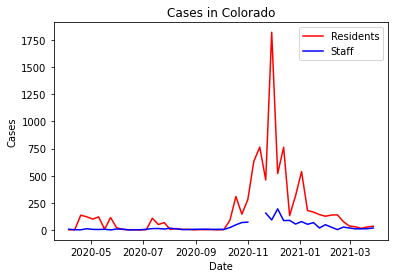

In [16]:
#Spaghetti Plot (not working well-maybe normalization?)

fig1= df1[['Residents.Confirmed','Date']].groupby('Date').mean()
  
fig2=df1[['Staff.Confirmed','Date']].groupby('Date').mean()

fig3=df1[['State.Confirmed','Date']].groupby('Date').mean()


plt.plot(fig1, color='r', label='Residents')
plt.plot(fig2, color='b', label='Staff')
#plt.plot(fig3, color='g', label='Community')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Cases in Colorado")
plt.legend()
plt.show()



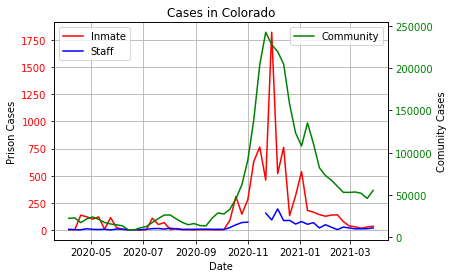

In [17]:
fig1= df1[['Residents.Confirmed','Date']].groupby('Date').mean()
fig2=df1[['Staff.Confirmed','Date']].groupby('Date').mean()
fig3=df1[['State.Confirmed','Date']].groupby('Date').mean()


fig, ax = plt.subplots()
ax.plot(fig1, color='red', label='Inmate')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(fig3, color='green', label='Community')
ax2.tick_params(axis='y', labelcolor='green')
ax.plot(fig2, color='b', label='Staff')

# Naming the x-axis, y-axis and the whole graph
plt.title("Cases in Colorado")
ax.grid()
ax.set_xlabel("Date")
ax.set_ylabel("Prison Cases")
ax2.set_ylabel("Comunity Cases")
plt.legend()
ax2.legend(loc=1)
ax.legend(loc=2)
plt.show()

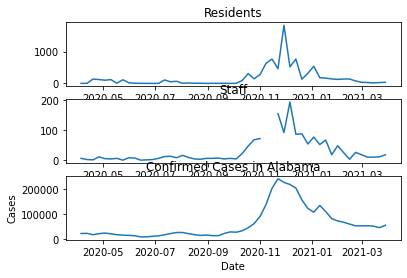

In [18]:
figure, axis = plt.subplots(3, 1)
fig1= df1[['Residents.Confirmed','Date']].groupby('Date').mean()
axis[0].plot(fig1)
axis[0].set_title("Residents")
  
fig2=df1[['Staff.Confirmed','Date']].groupby('Date').mean()
axis[1].plot(fig2)
axis[1].set_title("Staff")
  
fig3=df1[['State.Confirmed','Date']].groupby('Date').mean()
axis[2].plot(fig3)
axis[2].set_title("Community")

plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Confirmed Cases in Alabama")

plt.show()

In [19]:
fig = px.line(df1.reset_index(), x='Date', y='Residents.Confirmed', title='Inmate New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [28]:
import plotly.express as px
fig2 = px.line(df1.reset_index(), x='Date', y='Staff.Confirmed', title='Staff New Cases')
fig2.update_xaxes(
    rangeslider_visible=True,
)
fig2.show()

In [29]:
import plotly.express as px
fig3 = px.line(df1.reset_index(), x='Date', y='State.Confirmed', title='State New Cases')
fig3.update_xaxes(
    rangeslider_visible=True,
)
fig3.show()

# Anomaly Detection

In [30]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=0.03)
model.fit(df1[['Residents.Confirmed']])
df1['outliers']=pd.Series(model.predict(df1[['Residents.Confirmed']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
df1.query('outliers=="yes"')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed,outliers
Date,,,,,


In [31]:
fig = px.scatter(df1.reset_index(), x='Date', y='Residents.Confirmed', color='outliers', hover_data=['Date'], title='Inmate New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

KeyError: ignored

In [32]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=0.004)
model.fit(df1[['Staff.Confirmed']])
df1['outliers']=pd.Series(model.predict(df1[['Staff.Confirmed']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
df1.query('outliers=="yes"')

ValueError: ignored

In [33]:
fig = px.scatter(df1.reset_index(), x='Date', y='Staff.Confirmed', color='outliers', hover_data=['Date'], title='Staff New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

KeyError: ignored

In [34]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=0.01)
model.fit(df1[['State.Confirmed']])
df1['outliers']=pd.Series(model.predict(df1[['State.Confirmed']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
df1.query('outliers=="yes"')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed,outliers
Date,,,,,


In [35]:
fig = px.scatter(df1.reset_index(), x='Date', y='State.Confirmed', color='outliers', hover_data=['Date'], title='State New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

KeyError: ignored

# Prediction


In [36]:
import matplotlib.dates as mdates
import plotly.graph_objs as go
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [37]:
df1.set_index(['Date'], inplace = True) 
df1.index=pd.to_datetime(df1.index)

KeyError: ignored

In [22]:
df1=df1.drop(columns=['State','outliers'],axis=1)
x=np.arange(len(df1)).reshape(-1,1)
y=df1.values
y

KeyError: ignored

In [ ]:
data1=pd.DataFrame(df1)
data1

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [ ]:
test = np.arange(12).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
prediction

In [ ]:
week = [df1.index[51] + timedelta(weeks=i) for i in range(1,len(prediction)+1)]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.DataFrame(prediction, dt_idx, columns=['Residents.Confirmed', 'Staff.Confirmed', 'State.Confirmed'])
predicted_count

In [ ]:
predicted_df=pd.concat([df1,predicted_count])
predicted_df.index.name= 'Date'
predicted_df


In [ ]:

pd.plotting.register_matplotlib_converters()

fig1=predicted_df[['Residents.Confirmed']].groupby('Date').mean()
fig2=predicted_df[['Staff.Confirmed']].groupby('Date').mean()
fig3=predicted_df[['State.Confirmed']].groupby('Date').mean()


fig, ax = plt.subplots()
ax.plot(fig1, color='red', label='Inmate')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(fig3, color='green', label='Community')
ax2.tick_params(axis='y', labelcolor='green')

ax.plot(fig2, color='b', label='Staff')
# Naming the x-axis, y-axis and the whole graph
plt.title("Cases in Alabama")
ax.grid()
ax.set_xlabel("Date")
ax.set_ylabel("Prison Cases")
ax2.set_ylabel("Comunity Cases")
plt.legend()
ax.legend(loc=2)
plt.show()

In [ ]:
fig = px.scatter(predicted_df.reset_index(), x='Date', y='Residents.Confirmed', hover_data=['Date'], title='Inmate New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()